# kaggle

In [ ]:
# https://www.kaggle.com/general/74235
!pip -q install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abdallahalidev/plantvillage-dataset # Copy API command

100% 2.04G/2.04G [00:23<00:00, 35.8MB/s]



# unzip

In [ ]:
# https://drive.google.com/file/d/1hW4otiVDOKjfl2K3UY2fFbMH2j7FyqVw/view?usp=sharing
# drive'a kısayol ekle deyip colab'tan çekebilirsiniz
!unzip -q drive/MyDrive/datasets/plantvillage-dataset.zip

# import

In [ ]:
import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models

# dataset

In [ ]:
files = glob.glob("plantvillage dataset/**/**/*.*")
len(files), list(np.random.choice(files, 10))

(162916,
 ['plantvillage dataset/segmented/Tomato___Bacterial_spot/cb70e79d-a282-448e-a300-7f880a08cd70___GCREC_Bact.Sp 6332_final_masked.jpg',
  'plantvillage dataset/segmented/Pepper,_bell___healthy/aef76e6b-3245-4653-887a-a64d76a93bb8___JR_HL 8042_final_masked.jpg',
  'plantvillage dataset/segmented/Tomato___Bacterial_spot/a036424b-a20f-438b-895d-3d6cd284822c___GCREC_Bact.Sp 5644_final_masked.jpg',
  'plantvillage dataset/grayscale/Orange___Haunglongbing_(Citrus_greening)/6eb940fa-5ae3-456f-886a-7c7f4bb7c245___UF.Citrus_HLB_Lab 1132.JPG',
  'plantvillage dataset/color/Orange___Haunglongbing_(Citrus_greening)/2ea24019-ba16-4c6b-85bd-edbc7da1dfa4___CREC_HLB 4976.JPG',
  'plantvillage dataset/grayscale/Tomato___Spider_mites Two-spotted_spider_mite/9a6e4f1d-4c6d-4dab-8607-f914034d82d6___Com.G_SpM_FL 9619.JPG',
  'plantvillage dataset/color/Tomato___healthy/d41e126d-fc0d-4224-96e0-2d5ae074e4ac___RS_HL 9933.JPG',
  'plantvillage dataset/grayscale/Blueberry___healthy/6eac2d81-1878-4cd5-860

## samples

(256, 256, 3)


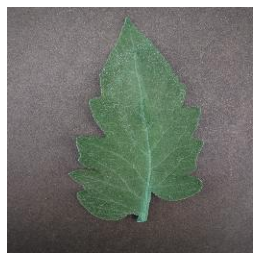

In [ ]:
path = "plantvillage dataset/color/Tomato___healthy/0c8c9c80-b7e0-47a7-81d3-b5a2174e545d___GH_HL Leaf 496.1.JPG"
img = cv2.imread(path, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.tight_layout()
plt.axis("off")
plt.show()

(256, 256, 3)


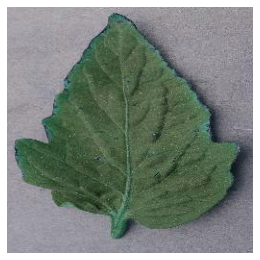

In [ ]:
path = "plantvillage dataset/color/Tomato___Bacterial_spot/12e9560a-01a5-4d97-a911-409c11cd0301___GCREC_Bact.Sp 3117.JPG"
img = cv2.imread(path, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.tight_layout()
plt.axis("off")
plt.show()

## color

In [ ]:
color = glob.glob("plantvillage dataset/color/**/*.*")
np.random.shuffle(color)
len(color), color[:10]

(54305,
 ['plantvillage dataset/color/Apple___Black_rot/5f569320-f84c-4a08-b414-1fd93f7e382b___JR_FrgE.S 8661.JPG',
  'plantvillage dataset/color/Squash___Powdery_mildew/ff0aa609-e2fc-46ab-8a11-c40307664a01___UMD_Powd.M 9840.JPG',
  'plantvillage dataset/color/Pepper,_bell___Bacterial_spot/13955856-c347-4039-ba30-09ea39d66534___NREC_B.Spot 9114.JPG',
  'plantvillage dataset/color/Tomato___Late_blight/1def69ef-c2f3-4052-8f02-b397428c7580___GHLB2 Leaf 8627.JPG',
  'plantvillage dataset/color/Corn_(maize)___Common_rust_/RS_Rust 2679.JPG',
  'plantvillage dataset/color/Soybean___healthy/a4d6fef5-f1d3-474c-a242-bcbc4c4561c6___RS_HL 3177.JPG',
  'plantvillage dataset/color/Apple___Black_rot/e3eead59-f821-41dd-9794-ba3ad35c71c7___JR_FrgE.S 2937.JPG',
  'plantvillage dataset/color/Tomato___Late_blight/cd97ced1-2870-4f00-b7c7-37b8903378b9___RS_Late.B 6926.JPG',
  'plantvillage dataset/color/Strawberry___Leaf_scorch/a4b70461-267f-4806-9e18-405e62f80bdb___RS_L.Scorch 1340.JPG',
  'plantvillage da

In [ ]:
split = int(len(color) * 0.8)
train_path = color[:split]
test_path = color[split:]
len(color), len(train_path), len(test_path)

(54305, 43444, 10861)

## loader

In [ ]:
# https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9
# https://www.topcoder.com/blog/image-classification-with-pytorch/
# https://hackernoon.com/binary-face-classifier-using-pytorch-2d835ccb7816

class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.transform = transform
        self.targets = []
        for d in self.data_path:
            p1 = d.split("___", 1)[1]
            if p1.split("/", 1)[0] == "healthy":
                self.targets.append(0)
            else:
                self.targets.append(1)
        
        print("data: {}, targets: {}".format(len(self.data_path), len(self.targets)))
        print("0_count: {}, 1_count: {}".format(self.targets.count(0), self.targets.count(1)))

        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img = Image.open(self.data_path[idx])
        img = np.array(img.convert("RGB"))
        # img = img.transpose((2, 0, 1))
        target = self.targets[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, target

## model

In [ ]:
class Net(nn.Module):
    def __init__(self, out_size):
        super(Net, self).__init__()
        self.out_size = out_size

        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)

        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(32 * 126 * 126, out_size)
    
    def forward(self, x):
        # x -> [batch_size, channel, width, height]
        # x -> [128, 3, 256, 256]
        
        x = self.relu(self.conv1(x)) # x -> [128, 16, 254, 254]
        x = self.relu(self.conv2(x)) # x -> [128, 32, 252, 252]
        
        x = self.pool(x)             # x -> [128, 32, 126, 126]
        
        x = torch.flatten(x, 1)      # x -> [128, 32 * 126 * 126]
        
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=1)

## train

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target.type(torch.LongTensor).cuda())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return running_loss / batch_idx

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target.type(torch.LongTensor).cuda(), reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

In [ ]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PlantDataset(train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = PlantDataset(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

"""
train_dataset = datasets.ImageFolder("plantvillage dataset/color/", transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = datasets.ImageFolder("plantvillage dataset/color/", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
"""

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(2).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00002, momentum=0.9)

data: 43444, targets: 43444
0_count: 12048, 1_count: 31396
data: 10861, targets: 10861
0_count: 3036, 1_count: 7825


In [ ]:
loss_values = []
accuracy_values = []
test(model, device, test_loader)
for epoch in range(5):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    loss_values.append(train_loss)

    test_acc = test(model, device, test_loader)
    accuracy_values.append(test_acc)

torch.save(model.state_dict(), "plant_model.pth")


Test set: Average loss: 0.6825, Accuracy: 6809/10861 (63%)

Train Epoch: 1 [0/43444 (0%)]	Loss: 0.682210
Train Epoch: 1 [640/43444 (1%)]	Loss: 0.630599
Train Epoch: 1 [1280/43444 (3%)]	Loss: 0.609852
Train Epoch: 1 [1920/43444 (4%)]	Loss: 0.594343
Train Epoch: 1 [2560/43444 (6%)]	Loss: 0.659982
Train Epoch: 1 [3200/43444 (7%)]	Loss: 0.573208
Train Epoch: 1 [3840/43444 (9%)]	Loss: 0.565506
Train Epoch: 1 [4480/43444 (10%)]	Loss: 0.501181
Train Epoch: 1 [5120/43444 (12%)]	Loss: 0.525488
Train Epoch: 1 [5760/43444 (13%)]	Loss: 0.540369
Train Epoch: 1 [6400/43444 (15%)]	Loss: 0.455405
Train Epoch: 1 [7040/43444 (16%)]	Loss: 0.545638
Train Epoch: 1 [7680/43444 (18%)]	Loss: 0.437169
Train Epoch: 1 [8320/43444 (19%)]	Loss: 0.486011
Train Epoch: 1 [8960/43444 (21%)]	Loss: 0.418426
Train Epoch: 1 [9600/43444 (22%)]	Loss: 0.467778
Train Epoch: 1 [10240/43444 (24%)]	Loss: 0.487943
Train Epoch: 1 [10880/43444 (25%)]	Loss: 0.454767
Train Epoch: 1 [11520/43444 (27%)]	Loss: 0.466642
Train Epoch: 1 [

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape, target, target.shape)
    break

torch.Size([128, 3, 256, 256]) tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1.]) torch.Size([128])


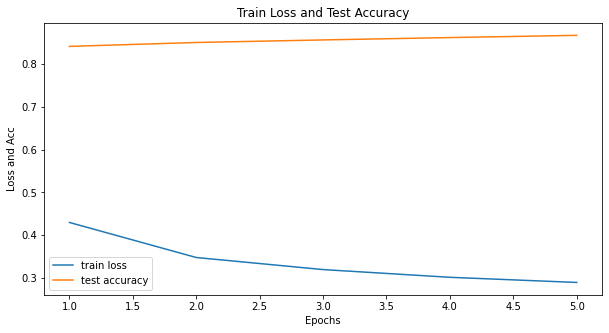

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.title('Train Loss and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 32, 252, 252]           4,640
              ReLU-4         [-1, 32, 252, 252]               0
         MaxPool2d-5         [-1, 32, 126, 126]               0
            Linear-6                    [-1, 2]       1,016,066
Total params: 1,021,154
Trainable params: 1,021,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 50.63
Params size (MB): 3.90
Estimated Total Size (MB): 55.28
----------------------------------------------------------------
